<a href="https://colab.research.google.com/github/Sompote/RIC_predict/blob/main/attention_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [80]:
#preparing data
#Transformer Autoencoder to predict RIC combind model by Dr. Sompote Youwai 2023
import numpy as np
import pandas as pd

# Import libraries
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd



df = pd.read_excel('/content/drive/MyDrive/RIC/Data_RIC.xlsx')
data=np.array(df)
X=data[:,1:28]
Y=data[:,34:61]
x_feature=data[:,28:31]
n_feature=x_feature.shape[1]
n_sequence=X.shape[1]


In [81]:
#scale data
X_train=X
Y_train=Y
sc_y=StandardScaler()
sc = StandardScaler()
sc_f=StandardScaler()
X_feature=x_feature
X_train=X

x_train = sc.fit_transform(X_train)
y_train=sc_y.fit_transform(Y_train)
x_feature=sc_f.fit_transform(x_feature)



In [82]:
X_train_CNN=np.zeros((X_train.shape[0],X_train.shape[1],X_feature.shape[1]+1))
X_train_CNN[:,:,0]=x_train
for i in range(0,(X.shape[0])):
  X_train_CNN[i,:,1]=x_feature[i,0]
  X_train_CNN[i,:,2]=x_feature[i,1]
  X_train_CNN[i,:,3]=x_feature[i,2]

In [83]:

#split data
X_train, X_test, Y_train, Y_test = train_test_split(X_train_CNN, y_train, test_size=0.1)

In [60]:
X_train.shape

(25, 27, 3)

In [86]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from tensorflow.keras import *

def transformer_encoder(inputs, head_size, num_heads, ff_dim,
                        dropout=0, attention_axes=1):
  """
  Creates a single transformer block.
  """
  x = layers.LayerNormalization(epsilon=1e-6)(inputs)
  x = layers.MultiHeadAttention(
      key_dim=head_size, num_heads=num_heads, dropout=dropout,
      attention_axes=attention_axes
      )(x, x)
  x = layers.Dropout(dropout)(x)
  res = x + inputs

    # Feed Forward Part
  x = layers.LayerNormalization(epsilon=1e-6)(res)
  x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
  x = layers.Dropout(dropout)(x)
  x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
  return x + res

def build_transfromer(head_size,
                      num_heads,
                      ff_dim,
                      num_trans_blocks,
                      mlp_units, dropout=0, mlp_dropout=0) -> tf.keras.Model:
  """
  Creates final model by building many transformer blocks.
  """
  n_timesteps, n_features, n_outputs = n_sequence, n_feature+1, n_sequence
  inputs = tf.keras.Input(shape=(n_timesteps, n_features))
  x = inputs
  for _ in range(num_trans_blocks):
    x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

  x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
  for dim in mlp_units:
    x = layers.Dense(dim, activation="sigmoid")(x)
    x = layers.Dropout(mlp_dropout)(x)

  outputs = layers.Dense(n_outputs, activation='linear')(x)
  return tf.keras.Model(inputs, outputs)

transformer = build_transfromer(head_size=64, num_heads=5, ff_dim=2,
                                num_trans_blocks=4, mlp_units=[256,100,50],
                                mlp_dropout=0.10, dropout=0.10)

transformer.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["mae", 'mape'],
)

#callbacks = [tf.keras.callbacks.EarlyStopping(patience=50, restore_best_weights=True)]

t_hist = transformer.fit(X_train, Y_train, batch_size=20,epochs=5000,
                         validation_data=(X_test, Y_test),verbose=1)

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 113ms/step - loss: 0.0572 - mae: 0.1707 - mape: 64.8362 - val_loss: 0.5868 - val_mae: 0.4617 - val_mape: 103.8368
Epoch 2502/5000
2/2 [==============================] - 0s 100ms/step - loss: 0.0532 - mae: 0.1625 - mape: 69.7101 - val_loss: 0.5856 - val_mae: 0.4616 - val_mape: 104.0217
Epoch 2503/5000
2/2 [==============================] - 0s 83ms/step - loss: 0.0740 - mae: 0.1959 - mape: 73.2029 - val_loss: 0.5847 - val_mae: 0.4611 - val_mape: 104.0383
Epoch 2504/5000
2/2 [==============================] - 0s 95ms/step - loss: 0.0765 - mae: 0.1976 - mape: 87.7557 - val_loss: 0.5839 - val_mae: 0.4609 - val_mape: 104.1022
Epoch 2505/5000
2/2 [==============================] - 0s 101ms/step - loss: 0.0519 - mae: 0.1583 - mape: 57.2555 - val_loss: 0.5813 - val_mae: 0.4598 - val_mape: 103.7168
Epoch 2506/5000
2/2 [==============================] - 0s 105ms/step - loss: 0.0635 - mae: 0.1724 - mape: 7

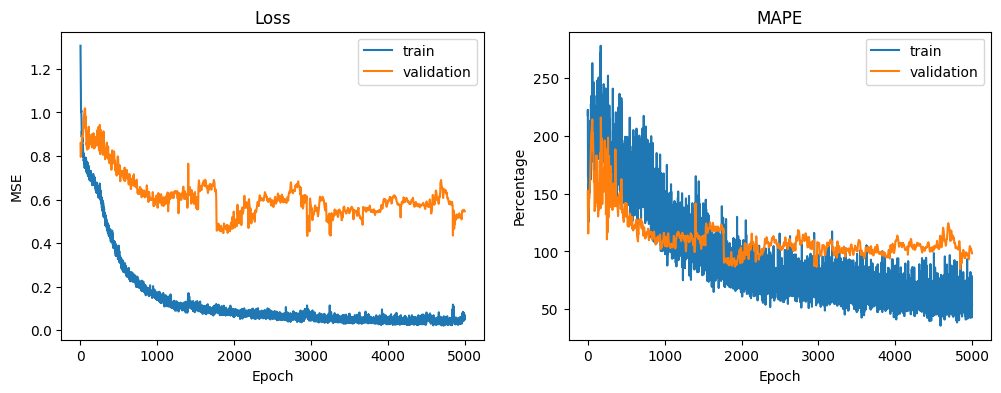

In [87]:

# plot the loss and mape for train and validation sets
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(t_hist.history['loss'], label='train')
plt.plot(t_hist.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(t_hist.history['mape'], label='train')
plt.plot(t_hist.history['val_mape'], label='validation')
plt.title('MAPE')
plt.xlabel('Epoch')
plt.ylabel('Percentage')
plt.legend()

plt.show()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 27, 4)]      0           []                               
                                                                                                  
 layer_normalization_104 (Layer  (None, 27, 4)       8           ['input_14[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 multi_head_attention_52 (Multi  (None, 27, 4)       6084        ['layer_normalization_104[0][0]',
 HeadAttention)                                                   'layer_normalization_104[0][0]']
                                                                                           

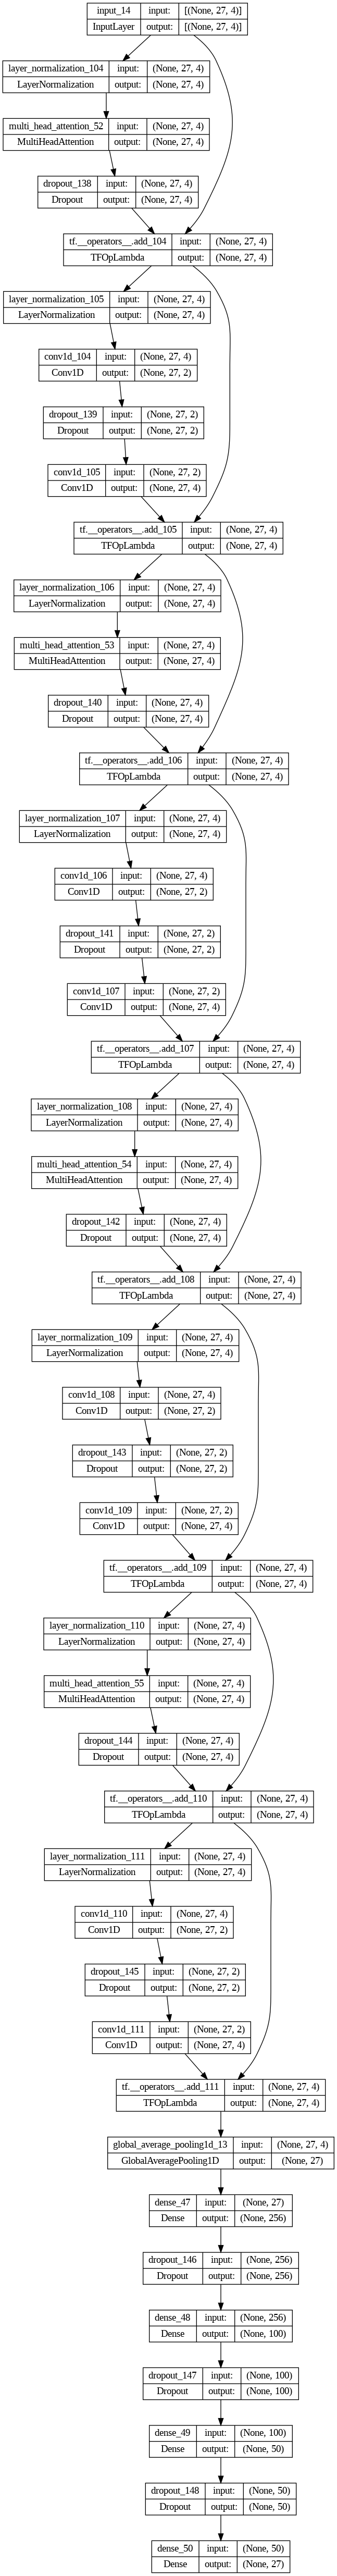

In [88]:
# plot and save your model
import tensorflow as tf
transformer.summary()
img_file = 'model2.png'
tf.keras.utils.plot_model(transformer, to_file=img_file, show_shapes=True, show_layer_names=True)

In [89]:
#validation
x_predictn=np.zeros((1,27))
#x_predictn[0,:]=[10,18,18,20,25,18,20,18,5,2,10,9,10,5,8,6,6,4,7,12,23,24,25,25,54,27,23]
x_predictn[0,:]=data[17,1:28]

X_predict = sc.transform(x_predictn)
x_feature=np.zeros((1,3))
x_feature[0,0]=100 #blow
x_feature[0,1]=18 #fine
x_feature[0,2]=5 #thickness
X_feature = sc_f.transform(x_feature)
#set up calculation matrix
x_cal=np.zeros((1,27,4))
x_cal[:,:,0]=X_predict
x_cal[:,:,1]=X_feature[0,0]
x_cal[:,:,2]=X_feature[0,1]
x_cal[:,:,3]=X_feature[0,2]
y=transformer.predict(x_cal)
y=sc_y.inverse_transform(y)
print(y)
#plot

print(y)
#plot


1/1 [==============================] - 1s 722ms/step
[[ 2.8573396  4.139951   4.152663   5.8480105  9.493012  12.411698
  14.00094   13.264226  14.671339  12.010894   3.2223601  1.5695763
   1.8866334  3.7579598  3.4225953  3.4745264  4.325583   4.4491568
   5.711444   7.4575996  6.9735374  4.543278   4.4680142  5.1712813
   5.100855   5.6464562  6.391544 ]]
[[ 2.8573396  4.139951   4.152663   5.8480105  9.493012  12.411698
  14.00094   13.264226  14.671339  12.010894   3.2223601  1.5695763
   1.8866334  3.7579598  3.4225953  3.4745264  4.325583   4.4491568
   5.711444   7.4575996  6.9735374  4.543278   4.4680142  5.1712813
   5.100855   5.6464562  6.391544 ]]


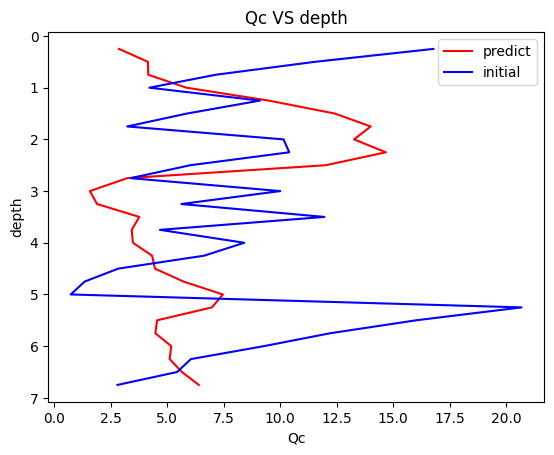

In [90]:
import matplotlib.pyplot as plt

# Define the x-axis and corresponding y-axis values as lists

ydist=[0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5,2.75,3,3.25,3.5,3.75,4,4.25,4.5,4.75,5,5.25,5.5,5.75,6,6.25,6.5,6.75]


# Plot them on canvas using plt.plot() function
plt.plot(y[0,:], ydist,color='red',label='predict')
plt.plot(x_predictn[0,:], ydist,color='blue',label='initial')
plt.legend()


# Give a name to x-axis and y-axis using plt.xlabel() and plt.ylabel() functions
plt.xlabel("Qc")
plt.ylabel("depth")

# Give a title to your plot using plt.title() function
plt.title("Qc VS depth")
# Get the current axes instance
ax = plt.gca()

# Invert the y-axis
ax.invert_yaxis()

# Finally, to view your plot, we use plt.show() function
plt.show()